<a href="https://colab.research.google.com/github/Duygubirol/NLP/blob/main/DS_Technical_Assignment_Duygu_Ekinci_Birol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This particular notebook has been specifically designed to participate in the  `Data Science Challenge` that has been put forth by `Resourcefull Humans`.  
`The primary objective of this notebook` is to formulate and develop a highly advanced sentiment analysis system that possesses the unique and specialized ability to accurately identify humorous comments with excellent scores and classify them accordingly into humor and non-humor categories.
To achieve this goal, I have ingeniously chosen to employ and utilize machine learning technique known as a pre-trained transformer BERT model.

Hugging Face offers three distinct methods for fine-tuning a pretrained text classification model: native PyTorch, Tensorflow Keras, and Pytroch Trainer. To showcase the strengths and weaknesses of each approach, I have chosen to implement two different methods: 

* Hugging Face Pytorch Trainer,
* and native Pytorch.

**Both approaches achieved similar levels of performance, with a slight difference in the measured accuracy and F1 score. `The Hugging Face PyTorch Trainer` achieved 98% accuracy and an F1 score, while training with `the PyTorch loop` achieved 99% accuracy and an F1 score.**


**Resource of article :** The research article related to this dataset: https://arxiv.org/abs/2004.12765

**Source of dataset** : https://www.kaggle.com/datasets/deepcontractor/200k-short-texts-for-humor-detection


# Structure of this Notebook

The notebook follows the widely recognized `CRISP-DM model`, which provides a clear and systematic approach to tackling complex and multifaceted data science challenges. 

This approach includes 5 highly structured and well-defined steps, which provide a clear and comprehensive roadmap to follow:

* **Step 1**. **Business Understanding**: The main objectives and goals of the project are identified and clarified. 
* **Step 2**. **Data Understanding**:  The data that is required to solve the business problem is collected, explored, and analyzed.
* **Step 3**. **Data Preparation**: The data is cleaned, transformed, and preprocessed to prepare it for modeling. 
* **Step 4**. **Modeling/Training with Hugging Face Pytorch Trainer**: It involves the application of the highly advanced and innovative Transformer trainer technique. This technique is designed to help fine-tune the Bert model and optimize its performance to achieve the best possible results. 
* **Step 5**. **Evaluation with Hugging Face Pytorch Trainer**: It involves the assessment and evaluation of the model's performance, which is essential for fine-tuning and optimizing its performance further.
* **Step 4a**. **Alternative Approach for Modeling/Training with native Pytorch**: It involves the use of an alternative approach that provides flexibility to fine-tune the model.
* **Step 5a**. **Alternative Approach for Evaluation with native Pytorch**: It allows to modify and adjust the evaluation criteria to suit the specific needs and requirements.

It is important to note that the deployment stage of the `CRISP-DM model` is not implemented in this project and is therefore out of scope. Nonetheless, the current version of the notebook provides users with a comprehensive and detailed guide to fine-tuning Bert using two different frameworks and following a highly structured and systematic approach to data science challenges.



# Step 0: Install And Import Python Libraries

In [ ]:
# Install libraries
!pip install transformers datasets
!pip install evaluate
!pip install scikit-plot
!pip install wordcloud
!pip install tensorflow
!pip install tensorflow-hub

In [116]:
# Data processing
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns
import scikitplot as skplt

# Preprocessing and Modeling
import re
import string
import torch
import sklearn
import tensorflow as tf
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, EarlyStoppingCallback, get_scheduler,BertModel, AdamW, TrainingArguments, Trainer
from datasets import Dataset
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
#from transformers import BertTokenizer, BertModel

# Model performance evaluation
import evaluate
import random
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# visualization theme
sns.set_theme(style="white")

# Step 1: Business Understanding



Before proceeding with the project, it is crucial to have a clear understanding of its primary objective. The aim of this project is to develop an automated system for detecting humor in text, with the ultimate goal of integrating it with any applications such as chatbots, and virtual assistants. 

# Step 2: Data Understanding with EDA

The second step is to download and read the dataset. Once the data has been loaded, the next step is to perform `exploratory data analysis (EDA)` in order to understand its structure, patterns, and relationships. This step is crucial as it helps to identify potential issues with the data, such as missing values and inconsistencies. Additionally, EDA can assist in selecting an appropriate model and tokenizer for the task at hand.


In [117]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The dataset comprises two columns: one containing the text and the other containing the corresponding sentiment label. Due to limited computational power, the first 100.000 rows were chosen for training and testing the data.

In [118]:
# Read the data
filepath = "/content/drive/Othercomputers/My Laptop/Documents/dataset.csv"
df_humor = pd.read_csv(filepath, nrows=100000)

# First 5 rows in the dataset
df_humor.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not running'",False
1,Watch: darvish gave hitter whiplash with slow pitch,False
2,What do you call a turtle without its shell? dead.,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind, new autopsy shows",False


The dataset contains 100.000 records, with the `text` column being of the `object` type and the `humor` column being of the `boolean` type. Before feeding the data into the ML model, `the data type of the humor` column needs to be changed.


There is no missing values in the dataset.

In [119]:
# Get the dataset information
df_humor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    99999 non-null  object
 1   humor   99999 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 879.0+ KB


The article mentioned in the introduction that duplicated rows are removed when creating a new dataset. Let's verify whether this is true or not.

In [120]:
# Check for duplicated columns
duplicated_columns = df_humor.columns.duplicated().sum()

# Print the number of duplicated columns
print(f"There are {duplicated_columns} duplicated columns in the DataFrame")

There are 0 duplicated columns in the DataFrame


Since the dataset is well-balanced, the model can learn from all classes equally, which can result in a more accurate and reliable model.

In [121]:
# Check the label distribution
df_humor["humor"].value_counts()

False    50021
True     49978
Name: humor, dtype: int64

The standard deviation in the dataset is low, indicating that there is low variance in the data.

In [122]:
# Compute the length of each text and display descriptive statistics
df_humor["text"].apply(lambda x: len(x.split(' '))).describe()

count    99999.000000
mean     11.988480   
std      2.766876    
min      1.000000    
25%      10.000000   
50%      12.000000   
75%      14.000000   
max      24.000000   
Name: text, dtype: float64

There are various factors to consider when choosing the optimal BERT model and its parameters. Findings from exploratory data analysis (EDA) can help in making this decision.
* One potential factor that can impact the accuracy of the BERT model is the difference in text length between labels. BERT models are trained on a large corpus of text, and the model learns to attend to all words in a given text. If there is a significant difference in text length between labels, the model may be biased towards longer texts, which can negatively affect its performance on shorter texts. The distribution of text length is analyzed to gain insights into the variation in length between the labels.
* Texts that are labeled as True (humor) are longer than texts that are labeled as False (non_humor).
* **However, in this case, the differences in word length between the two labels are not substantial. Therefore, the text length remains relatively consistent across each label, and any potential bias towards longer texts is less of a concern.**


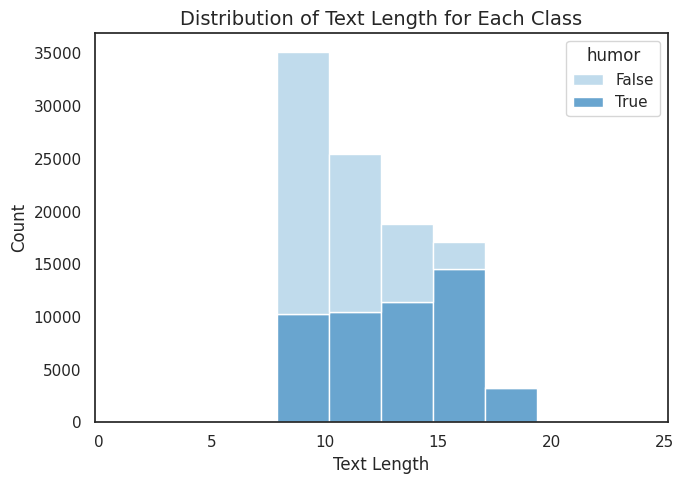

In [123]:
# Create histogram
sns.histplot(df_humor, x=df_humor["text"].apply(lambda x: len(x.split(' '))), hue="humor", multiple="stack",palette="Blues", bins=10)

# Add title and labels with adjusted font size
plt.title("Distribution of Text Length for Each Class", fontsize=14)
plt.xlabel("Text Length", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Adjust figure size and spacing
fig = plt.gcf()
fig.set_size_inches(7, 5)
plt.tight_layout()

# Show plot
plt.show()


* The length of the text and text characters can aid in determining the appropriate maximum sequence length for the BERT tokenizer. By examining the `Distribution of Text Character Length`, it can be concluded that there is **no need to set the max_length parameter to more than 100.**

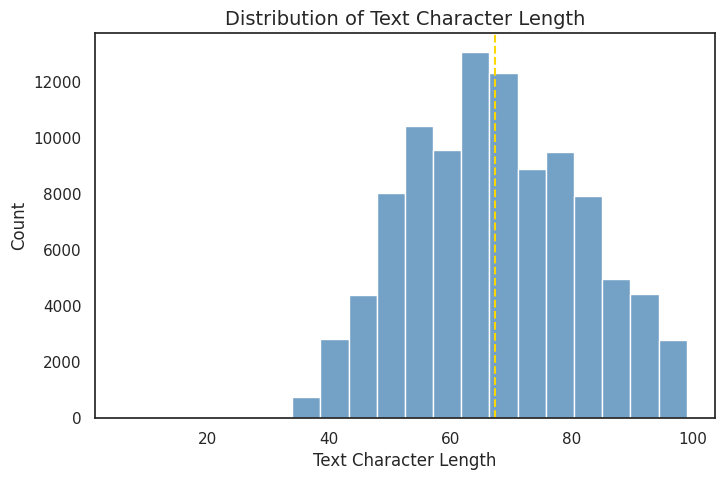

In [124]:
# Calculation of length for each character in the text
text_len = [len(x) for x in list(df_humor["text"])]

# Create a histogram
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(text_len, bins=20, color="steelblue")

# Set the plot title and x-y label
plt.xlabel("Text Character Length", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Text Character Length", fontsize=14)
plt.axvline(x=np.mean(text_len), color="gold", linestyle='--')

plt.show()

* The box plot shows outliers that can potentially have a negative impact on the model's performance. However, in this case, there is no significant difference between the outliers and the median. Additionally, the variance of the dataset is not high. Therefore, there is no need to remove any texts from the dataset.

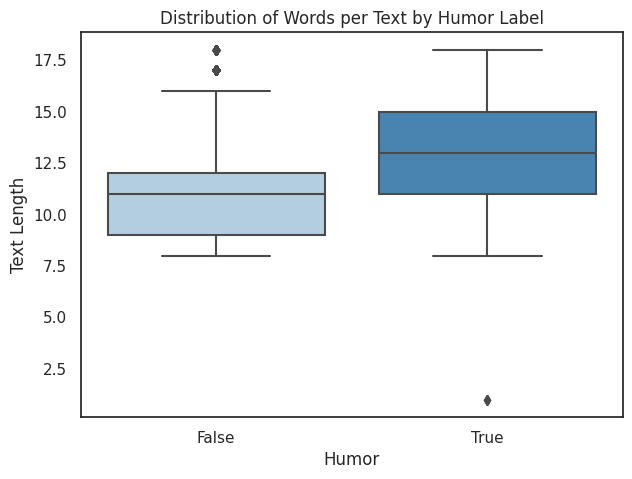

In [125]:
# Plot a boxplot of the number of words per text, grouped by label_name
sns.boxplot(x="humor", y=df_humor["text"].apply(lambda x: len(x.split())), data=df_humor,palette="Blues")

# Set the plot title and x-label
plt.title("Distribution of Words per Text by Humor Label")
plt.xlabel("Humor")
plt.ylabel("Text Length")

# Display the plot
plt.show()

# Step 3: Data Preparation





The Data Preparation stage is a crucial and important step to keep the quality of the data high and ensure accurate results from the model.

## Step 3.1: Prepare the data before tokenization

* Carrying out several text preprocessing steps before tokenization on all input texts resulted in a reduction in accuracy for both the train and test datasets. Therefore, it has been decided to proceed without applying certain preprocessing steps, such as replacing contractions and removing punctuation.

* As the Bert Tokenizer already performs several preprocessing steps on the input text, including text cleaning (such as removing HTML tags, URLs, and emojis), there is no need to apply further text cleaning steps. However, there are certain steps that must be applied before tokenizing and fine-tuning the model.

* To prepare the data for the machine learning model, the labels indicating the presence or absence of humor have been converted to numerical values. The label of False, which indicates no humor, has been converted to 0. Similarly, the label of True, which indicates the presence of humor, has been converted to 1.

In [126]:
# Replace the labels to integer before being used by a machine learning model
df_humor['humor'] = np.where((df_humor["humor"] == 'False'), 0, df_humor['humor'])
df_humor['humor'] = np.where((df_humor['humor'] == 'True'), 1, df_humor['humor'])

# show head 
df_humor.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not running'",0
1,Watch: darvish gave hitter whiplash with slow pitch,0
2,What do you call a turtle without its shell? dead.,1
3,5 reasons the 2016 election feels so personal,0
4,"Pasco police shot mexican migrant from behind, new autopsy shows",0


### Step 3.1.1: Split the dataset 

The data was divided into two sets, with 80% allocated for training and 20% reserved for testing.

 * **random_state=42:** The sampling result is reproducible by seting the random seed for split.
 * **stratify** is used to ensure that the split is stratified by the values in the `humor` column of the dataset to ensure that the proportion of samples from each class is roughly the same in both the training and test sets.

In [127]:
# Split dataset into train and test sets
train_data, test_data = train_test_split(df_humor, test_size=0.2, random_state=42,stratify=df_humor["humor"])

# Print number of records in train and test sets
print(f"The training dataset has {len(train_data)} records.")
print(f"The testing dataset has {len(test_data)} records.")

The training dataset has 79999 records.
The testing dataset has 20000 records.


The aim of this graph is to check whether the label distribution is similar between the train and test datasets to help model trained on the train dataset will perform well on the test dataset. 

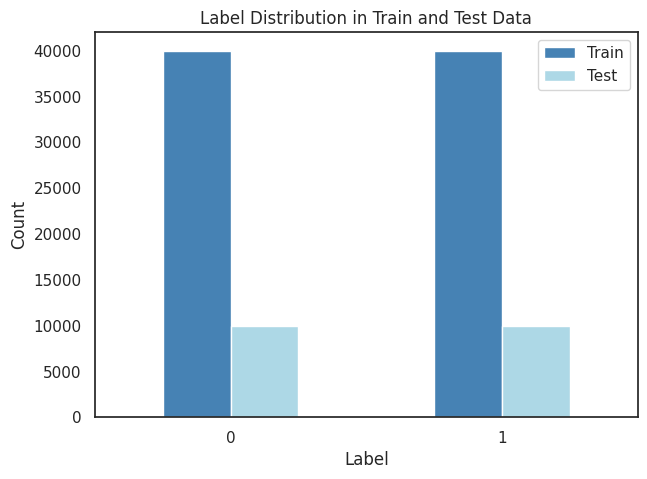

In [128]:
# Count the number of occurrences of each label in train_data and test_data
train_counts = train_data["humor"].value_counts()
test_counts = test_data["humor"].value_counts()

# Combine the train and test counts into a single DataFrame
df_counts = pd.concat([train_counts, test_counts], axis=1, keys=["Train", "Test"])

# Create a bar chart of the counts
colors = ["steelblue", "lightblue"]
ax = df_counts.plot(kind="bar", color=colors)
ax.set_xticklabels(["0", "1"], rotation=0, ha='center')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Train and Test Data')
plt.legend(["Train", "Test"])
plt.show()



### Step 3.1.2 : Convert Pandas Dataframe to Hugging Face Dataset

* This stage involves converting both the training and testing dataframes into a Hugging Face dataset that can be used with the Hugging Face Transformers library.

* One of the significant advantages of using the Hugging Face Dataset format is that it allows for efficient memory management, as the data can be memory-mapped to disk. This is particularly useful when dealing with large datasets that would otherwise exceed the available RAM memory.

* The resulting datasets can now be used with Hugging Face's Trainer class for fine-tuning a pre-trained language model on the text data.

In [129]:
# Convert pandas dataframe to Hugging Face dataset
hg_train_data = Dataset.from_pandas(train_data)
hg_test_data = Dataset.from_pandas(test_data)

`hg_train_data[0]` is used to access the first entry of the Hugging Face dataset. This entry is represented as a dictionary containing three keys: text, hunor label, and __index_level_0__ (an automatically generated field from the pandas dataframe).

In [130]:
hg_train_data[0]

{'text': "Why couldn't the melons be together? everyone knows melons cantaloupe.",
 'humor': 1,
 '__index_level_0__': 88392}

## Step 3.2: Tokenize the data 

* BERT utilizes a unique subword tokenization technique known as WordPiece. Therefore, it is crucial to use the same tokenizer during pre-training and fine-tuning to ensure consistency in the tokenization process. Hence, choosing the appropriate model prior to tokenization is essential.

* Numerous versions of BERT, such as **DistilBERT, TinyBERT, BERT_base and Bert_large**, have been applied. Due to the limited text length in the dataset, the first choose was DistilBERT. However, more complex and larger BERT models performed better than their smaller counterparts. 
* Bert_large_uncased also outperformed BERT_base_uncased, but the performance improvements were not substantial enough to warrant the additional computational resources required to use BERT large.

* Furthermore, some classifiers achieved perfect accuracy in distinguishing between a headline that was a humor and one that was not. Thus, utilizing `BERT_uncased`, the lowercase variant of BERT, increased the classification task's difficulty level and ensured that the classifiers' performance was not unrealistically high.




In [131]:
# Load the tokenizer from a pretrained model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

* **max_length=100:** This sets the maximum length of each tokenized text sequence to 100 tokens. If the input text is longer than 100 tokens, it will be truncated.
* **truncation=True:** If the input text is longer than max_length, this argument determines whether to truncate it or not. In this case, the input text will be truncated to a maximum of 100 tokens.
* **padding:** It pads the sequences to a maximum length of 100 tokens by adding padding tokens (e.g., [PAD]) to the end of shorter sequences.

In [132]:
# Function to tokenize data
def tokenize_dataset(data):
    return tokenizer(data["text"], 
                     max_length=100, 
                     truncation=True, 
                     padding="max_length")

# Tokenize both train and test dataset
dataset_train = hg_train_data.map(tokenize_dataset)
dataset_test = hg_test_data.map(tokenize_dataset)

Map:   0%|          | 0/79999 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

After tokenization, there are  6 features, `'review'`, `'label'`, `'__index_level_0__'`, `'input_ids'`, `'token_type_ids'`, and `'attention_mask'` in both dataset. The number of rows is stored with `num_rows` in both train and test dataset.

In [133]:
print(dataset_train)
print(dataset_test)

Dataset({
    features: ['text', 'humor', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 79999
})
Dataset({
    features: ['text', 'humor', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 20000
})


## Step 3.3: Prepare the dataset before fine-tuning

During fine-tuning, the model has already been pre-trained on a large corpus of data, and it has learned to predict the target variable based on the input features. In the pre-training stage, the target variable is typically named "labels", and the model is designed to expect this naming convention. So I renamed the "humor" column as "labels".

In [134]:
# Rename humor column to labels because the model expects the name labels
columns_to_rename = {"humor": "labels"}
dataset_train = dataset_train.rename_columns(columns_to_rename)
dataset_test = dataset_test.rename_columns(columns_to_rename)

print("Training dataset:", dataset_train)
print("Test dataset:", dataset_test)

Training dataset: Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 79999
})
Test dataset: Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 20000
})


# Step 4: Modeling with Hugging Face Pytorch Trainer

* `AutoModelForSequenceClassification` is a general class which allows user to experiment with different pre-trained transformer models, without having to write separate code for each individual model.
* `num_labels` indicates the number of classes. The dataset has two classes, 0 and 1, so `num_labels=2`.

In [135]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

**Hugging face explanation of warning:** You will see a warning about some of the pretrained weights not being used and some weights being randomly initialized. Don’t worry, this is completely normal! The pretrained head of the BERT model is discarded, and replaced with a randomly initialized classification head. You will fine-tune this new model head on your sequence classification task, transferring the knowledge of the pretrained model to it.

## Step 4.1: Set Training Argument

 `TrainingArguments` provides a lot of flexibility in fine-tuning the transfer learning model. 
 
* BERT is a very large model with millions of parameters, and it can be difficult to train effectively using standard optimization methods. So, for the purposes of fine-tuning, the authors of `Attention is All You Need` recommend choosing from the following values (from Appendix A.3 of the BERT paper):

* Batch size: 16, 32

* Learning rate (Adam): 5e-5, 5e-6, 3e-5, 2e-5, 5e-6

* Number of epochs: 2, 3, 4

So I followed recommended values for some parameters.

Source of article : https://arxiv.org/abs/1706.03762

* **logging_strategy="epoch":** Logging is done at the end of each epoch.

* **logging_steps:** The frequency of logging and saving checkpoints during training is 100 (A common value of logging and saving checkpoints is 100-500 during training).

* **num_train_epochs:** I started with 4 epochs for fine-tuning the model. After the first epoch, the training loss was likely decreasing, which suggests that the model is learning from the data. However, after the third epoch, the training loss did not decrease further. This indicates that the model has already converged to its optimal state, and further training may not result in any significant improvement.So I decided to use 3 epoch.

* **per_device_train_batch_size and per_device_eval_batch_size:** For BERT-base models, a common value is 16-32, but this can depend on the available memory on your GPU. I started to apply and 16 and get good results with 16.

* Default `learning rate` for trainer argument is AdamW which is an extension of the Adam optimizer that performs weight decay in a way that is compatible with adaptive gradient methods. When using Adam optimizer, weight decay is applied to both the weights and the bias terms, which may lead to a suboptimal solution. In contrast, AdamW applies weight decay only to the weights and not the bias terms, which results in better performance and convergence for deep neural networks, such as BERT.

* **save_strategy:** after each eopch, checkpoints are saved.

* **warmup_steps:** The number of warmup steps for the learning rate scheduler. A common value for BERT-base models is 10% of the total number of training steps.

* **evaluation_strategy and eval_steps:**  The evaluation results will be printed out at the end of each epoch. It's helpful for us to monitor the model performance during model fine-tuning (evaluation_strategy='epoch') and to evaluate every 100-500 steps (eval_steps=100-500).

* `load_best_model_at_end=True` indicates that the best model will be loaded at the end of the training. The default is False. 


In [136]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="./humor_detection_Bert1/",          
    logging_dir='./humor_detection_Bert1/logs',            
    logging_strategy='epoch',
    logging_steps=100,    
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,  
    learning_rate=5e-6,
    seed=42,
    save_strategy='epoch',
    evaluation_strategy='epoch',
    eval_steps=100,
    load_best_model_at_end=True,
    warmup_steps=1500
)

## Step 4.2: Set Evaluation Metrics

The Hugging Face Trainer does not automatically evaluate the model's performance during the training process so I needed to manually specify when and how to evaluate the model's performance.

The dataset is highly balanced, which makes the `f1` score an appropriate evaluation metric as it balances recall and precision.

In [137]:
# Function to compute the metric
def compute_metrics(eval_pred):
    metric = evaluate.load("f1")
    logits, labels = eval_pred
    # probabilities = tf.nn.softmax(logits)
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

## Step 4.3: Train Model Using Transformer Trainer

I trained the model using the transformer `Trainer`.
* `model` is used for training, evaluation, or prediction by the `Trainer`.
* The dataset_train and dataset_test is in `Dataset` format, the unused columns such as `__index_level_0__` and `text` will be automatically ignored. 
* `The EarlyStoppingCallback` takes an argument called early_stopping_patience, which is set to 1 in this case. This means that if the model's performance on the validation set does not improve for 1 epoch, the training process will be stopped.This approach is a useful to prevent overfitting and improve the generalization performance of machine learning models. 
* Training was stopped after second epoch because model`s performance on validation did not improve.


In [138]:
# Train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_test,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.142400,0.072523,0.982289
2,0.048400,0.072739,0.984259


TrainOutput(global_step=10000, training_loss=0.09539766540527343, metrics={'train_runtime': 2902.5078, 'train_samples_per_second': 82.686, 'train_steps_per_second': 5.168, 'total_flos': 8222117702244000.0, 'train_loss': 0.09539766540527343, 'epoch': 2.0})

* During training, the model is evaluated by loss on both the training set and the validation set after each epoch.
* Validation loss is often a more precise measure than accuracy. Because validation loss takes into account how far off the predicted values are from the true values. In contrast, accuracy only provides a binary measure of correctness or incorrectness, without taking into account how close the predicted values are to the true values. So, it is important to check validation loss during training and evaluation.
* The model appears to have performed well on both the training and validation sets. While the the training loss is going down with each epoch, the validation loss is decreasing which is indicating that the model is learning and improving its performance.

**Given these observations, it appears that there is not a significant issue with either overfitting or underfitting in this case.**


# Step 5: Evaluation with Hugging Face Pytorch Trainer

# Step 5.1: Make Predictions for Text Classification

We can see that the prediction has two columns. The first column is the predicted logit for label 0 and the second column is the predicted logit for label 1. 

In [139]:
# Predictions
y_pred = trainer.predict(dataset_test)

# Predicted logits
y_logits = y_pred.predictions

# First 5 predicted probabilities
y_logits[:5]

array([[-4.138164 ,  4.630439 ],
       [ 4.3046618, -4.249935 ],
       [ 4.2782083, -4.177214 ],
       [-4.3529663,  4.7370653],
       [ 4.3798413, -4.229246 ]], dtype=float32)

After applying softmax, the predicted probability for each review sums up to 1.

In [140]:
# Predicted probabilities
y_prob = tf.nn.softmax(y_logits)

# First 5 predicted logits
y_prob[:5]

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[1.5551661e-04, 9.9984443e-01],
       [9.9980742e-01, 1.9262033e-04],
       [9.9978727e-01, 2.1269845e-04],
       [1.1277178e-04, 9.9988723e-01],
       [9.9981767e-01, 1.8240714e-04]], dtype=float32)>

To get the predicted labels, `argmax` is used to return the index of the maximum probability for each review, which corresponds to the labels of zeros and ones.

In [141]:
# Predicted labels
y_pred_labels = np.argmax(y_prob, axis=1)

# First 5 predicted probabilities
y_pred_labels[:5]


array([1, 0, 0, 1, 0])

In [142]:
# Actual labels
y_test_labels = y_pred.label_ids

I created a new dataset to see actual and predicted labels together.

In [143]:
# add predicted labels as new column to test data to compare ground truth and predicted label
test_data_withpred = (
    test_data.assign(predicted_labels=y_pred_labels.tolist())
    .rename(columns={'predicted_labels': 'humor_pred'})
)
test_data_withpred

,text,humor,humor_pred
15438,How did the hipster burn his tongue? he drank the coffee before it was cool.,1,1
44571,"No, it's not ok to 'steal kisses' -- here's why",0,0
88893,"Donald trump parts ways with corey lewandowski, his campaign manager",0,0
9248,Whats the difference between 3 big cocks and a joke? your mom can't take a joke.,1,1
33274,Boston marathon bombing victim halloween costume prompts online fury,0,0
...,...,...,...
47926,5 ways you're trading incredible sex for a miserable job,0,0
92362,Gov to sign cannabis oil bill into law,0,0
36846,What did the agnostic dyslexic insomniac do? he stayed up all night wondering if there was a dog.,1,1
17505,'after earth' might just be an ode to scientology,0,0


By comparing the actual label and predicted label with the corresponding text, we can identify the reasons for `false negatives`. This approach also enables us to evaluate the quality of the data labels and perform `error analysis.`

In [144]:
pd.set_option('display.max_colwidth', 0)
test_data_withpred[(test_data_withpred['humor']==1) & 
        (test_data_withpred['humor_pred']!=1) ][0:10]

,text,humor,humor_pred
37302,"Live, laugh, love, dress up like a clown and wander around the woods at night",1,0
52152,"There's no creative way to arrange 29 sponsor logos. let it go, walkathon t-shirt designer.",1,0
59970,Population control: make birth control a psychedelic. you're welcome.,1,0
16363,Chemists confirm the existence of new type of bond james bond,1,0
54257,Dance dance revolution is an intense game but an even more intense to-do list,1,0
77471,A vasectomy can make a vas deferens in your life,1,0
26196,"It's not you, it's meat - vegan break up",1,0
88045,Incest fun for the whole family (probably a repost),1,0
25590,Surround yourself with people who will groom your eyebrows should you ever become comatose,1,0
6974,New study reveals that women slightly overweight live longer than the men who mention it,1,0


## 5.2: Model Performance Evaluation

Since the dataset is well-balanced, it may not be necessary to calculate The `Matthews correlation coefficient (MCC)` which is commonly used to evaluate the performance of imbalanced dataset. Instead, I calculated  and visualized several important metrics commonly used in classification problems to measure the model's performance. 


The `trainer.evaluate` function also provides a convenient way to obtain the loss and accuracy metrics for the testing dataset.

In [145]:
# Trainer evaluate
trainer.evaluate(dataset_test)

{'eval_loss': 0.07252321392297745,
 'eval_f1': 0.9822893736241745,
 'eval_runtime': 108.643,
 'eval_samples_per_second': 184.089,
 'eval_steps_per_second': 11.506,
 'epoch': 2.0}

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     10004
           1       0.98      0.98      0.98      9996

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



{'accuracy': 0.9823,
 'f1': 0.9822893736241745,
 'recall': 0.982092837134854,
 'precision': 0.9824859887910328,
 'confusion_matrix': <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f1689278160>}

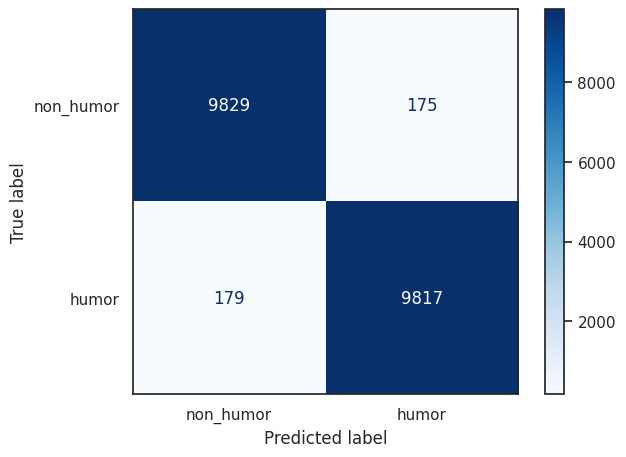

In [146]:
def evaluation_metrics(dataset_test):
    # Calculate accuracy, f1, recall, and precision
    accuracy = accuracy_score(y_test_labels, y_pred_labels)
    f1 = f1_score(y_test_labels, y_pred_labels)
    recall = recall_score(y_test_labels, y_pred_labels)
    precision = precision_score(y_test_labels, y_pred_labels)
    
    # Plot confusion matrix
    plt.rcParams['figure.figsize'] = (7, 5)
    confusion_matrix = metrics.confusion_matrix(y_test_labels, y_pred_labels)
    cm= metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["non_humor", "humor" ])
    cm.plot(cmap='Blues') 

    # Calculate classification report
    report = classification_report(y_test_labels, y_pred_labels)
    
    # Print classification report
    print("Classification Report:\n", report)
    
    # Return the results as a dictionary
    return {'accuracy': accuracy,
            'f1': f1,
            'recall': recall,
            'precision': precision,
            'confusion_matrix': cm}

evaluation_metrics(dataset_test)


A `false negative` occurs when the model predicts a sample as `non_humor` but it is actually `humor`. In other words, the model failed to detect humor in some samples, leading to a false negative prediction. In this case, I have `179 such false negatives`, meaning that the model missed 179 humorous samples.

On the other hand, a `false positive` occurs when the model predicts a sample as `humor` but it is actually `non_humor`. In other words, the model detected humor in some samples where there was none, leading to a `false positive` prediction. In this case, you have `175 such false positives`, meaning that the model incorrectly identified 175 non-humorous samples as humor.

## Step 5.2: Save the Model

`tokenizer.save_pretrained` saves the tokenizer information to the drive and `model.save_model` saves the model to the drive.

In [147]:
# Save tokenizer
tokenizer.save_pretrained('./humor_detection_Bert1/')

# Save model
trainer.save_model('./humor_detection_Bert1/')

In [148]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('./humor_detection_Bert1/')

# Load model
loaded_model = AutoModelForSequenceClassification.from_pretrained('./humor_detection_Bert1/')

# Step 4.a: Alternative Approach for Modeling/Traning with native Pytorch

This stage is the second approach to fine-tune Bert with Pytorch loops.
* I will continue for data preparation and training part in this section.
* As I mentioned in earlier steps, both the dataset_train and dataset_test are in the Dataset format. However, to train and evaluate these datasets by using a PyTorch loop, the `__index_level_0__` and `text` columns must be removed. This is because unlike the Hugging Face PyTorch trainer, the Python loop does not ignore unused columns.
* I have set the format of the dataset to return PyTorch tensors so that they can be used with PyTorch-based models.

In [149]:
# Remove the review and index columns because it will not be used in the model
columns_to_remove = ["text", "__index_level_0__"]
dataset_train = dataset_train.remove_columns(columns_to_remove)
dataset_test = dataset_test.remove_columns(columns_to_remove)

#Change the format to PyTorch tensors
dataset_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
dataset_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

print("Training dataset:", dataset_train)
print("Test dataset:", dataset_test)

Training dataset: Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 79999
})
Test dataset: Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 20000
})


* **torch.cuda.empty_cache():** PyTorch function used to free up GPU memory that may have been allocated by the program but is no longer needed. This can be useful to prevent out-of-memory errors that can occur when training large deep learning models on limited GPU memory.

* `DataLoader` is applied because training a model with large datasets can be computationally expensive and memory-intensive, so loading the data in smaller batches reduces the memory requirements of the model and makes it easier to train on limited hardware resources. Additionaly, mini-batches allow for parallel processing, which speeds up the training process. Finally, using mini-batches instead of the entire dataset helps to improve the generalization of the model, as it learns from a diverse set of examples in each batch.

* **shuffle=True:** The data will be shuffled each epoch. This is useful to prevent the model from overfitting to the order of the training data.

In [150]:
# Empty cache
torch.cuda.empty_cache()

# DataLoader
train_dataloader = DataLoader(dataset=dataset_train, shuffle=True, batch_size=16)
eval_dataloader = DataLoader(dataset=dataset_test, batch_size=16)

* Before training the model, Optimizer & Learning Rate Scheduler are defined. 
* Parameters for Bert model has already explained in the `Step 4.1: Set Training Argument`.
* Setting a low learning rate `lr`, as done in the code with `lr=5e-6`, means that during training, the optimizer will make small adjustments to the model's parameters. This can be helpful in situations where the dataset is complex or noisy, and the model requires more careful optimization to find the best set of parameters.A low learning rate can also help prevent the model from `overfitting` the training data. 
* Linear decay of learning rate is applied to reduces the learning rate `linearly` over time to help the model converge to a better solution. This means that the learning rate will be gradually reduced as the model trains, which will allow the model to fine-tune its parameters and avoid overfitting.

In [151]:
# Number of epochs
num_epochs = 3

# Number of training steps
num_training_steps = num_epochs * len(train_dataloader)

# Optimizer
optimizer = AdamW(params=model.parameters(), lr=5e-6)

# Set up the learning rate scheduler
lr_scheduler = get_scheduler(name="linear", 
                             optimizer=optimizer, 
                             num_warmup_steps=1500, 
                             num_training_steps=num_training_steps)

# Use GPU if it is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Pytorch Training loop:
* To monitor the progress of the training process, the tqdm library can be used to display a progress bar indicating the number of training steps completed.
* The code iterates over each epoch in the range num_epochs.
* The epoch_loss variable is initialized to 0 at the beginning of each epoch.
The code iterates over each batch in the train_dataloader, which is responsible for loading the training data in batches.
* For each batch, the model's parameters are updated based on the loss computed on the batch using backpropagation, the optimizer, and the learning rate scheduler.
* The epoch_loss is updated by adding the loss item to it for each batch. At the end of the epoch, the average epoch_loss is computed.

In [152]:
progress_bar = tqdm(range(num_training_steps))
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0
    
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()

        #to avoid accumulation of gradients from previous batches
        optimizer.zero_grad()
        
        # Update loss
        """
        Accumulate the training loss over all of the batches so that we can
        calculate the average loss at the end. `loss` is a Tensor containing a
        single value; the `.item()` function just returns the Python value 
        # from the tensor.
        """
        epoch_loss += loss.item()
        
        progress_bar.update(1)
        
    # Compute average F1 score and loss for the epoch
    epoch_loss /= len(train_dataloader)
    
    # Print epoch stats
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f"  Train Loss: {epoch_loss:.3f} ")

  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 1/3
  Train Loss: 0.037 
Epoch 2/3
  Train Loss: 0.020 
Epoch 3/3
  Train Loss: 0.009 


During the training, the loss (or error) on the training data decreased after each epoch of training. This can be a positive sign that the model is learning and improving its predictions over time. However, it is important to also evaluate the model's performance on a separate validation dataset to ensure that it is not overfitting to the training data.

# Step 5.a: Alternative Approach for Evaluation with native PyTorch

## Step 5.a.1: Model Performance Evaluation

Pytroch Evaluation Loop:
* Set the model to evaluation mode
* Initialize empty lists to store predictions and labels in case any need
* Loop through the evaluation dataloader and makes predictions using the model
* Store the predictions and labels in the respective lists
* Compute the confusion matrix and classification report using scikit-learn's metrics module
* Print the classification report
* Plot the confusion matrix using matplotlib's ConfusionMatrixDisplay function.

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     10004
           1       0.99      0.98      0.99      9996

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



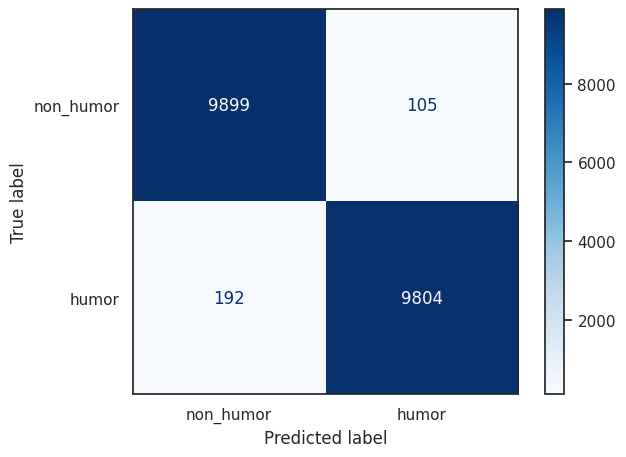

In [153]:
# Set model to evaluation mode
model.eval()

# Initialize variables for storing predictions and labels
all_predictions = []
all_labels = []

# Loop through evaluation dataloader
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    # Store predictions and labels
    all_predictions.extend(predictions.cpu())
    all_labels.extend(batch["labels"].cpu())

# Compute confusion matrix and classification report
confusion_matrix = metrics.confusion_matrix(all_labels, all_predictions)
class_report = classification_report(all_labels, all_predictions)

# Print confusion matrix and classification report
print("Classification Report:\n", class_report)

# Plot confusion matrix
plt.rcParams['figure.figsize'] = (7, 5)
cm= metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["non_humor", "humor" ])
cm.plot(cmap='Blues') 

A `false negative` occurs when the model predicts a sample as `non_humor` but it is actually `humor`. In other words, the model failed to detect humor in some samples, leading to a false negative prediction. In this case, I have `192 such false negatives`, meaning that the model missed 192 humorous samples.

On the other hand, a `false positive` occurs when the model predicts a sample as `humor` but it is actually `non_humor`. In other words, the model detected humor in some samples where there was none, leading to a `false positive` prediction. In your case, you have `105 such false positives`, meaning that the model incorrectly identified 105 non-humorous samples as humor.

## Step 5.a.2: Save the Model

`tokenizer.save_pretrained` saves the tokenizer information to the drive and `model.save_model` saves the model to the drive.

In [154]:
# Save tokenizer
tokenizer.save_pretrained('./humor_detection_Bert2/')

# Save model
model.save_pretrained('./humor_detection_Bert2/')

In [155]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('./humor_detection_Bert2/')

# Load model
loaded_model = AutoModelForSequenceClassification.from_pretrained('./humor_detection_Bert2/')

## Step 5.a.3: A Comparison of Two Approaches

Using a PyTorch training loop gives user full control over the training process and allows user to customize the optimization algorithm, learning rate schedule, and other hyperparameters. This approach requires to write more code, but it gives you more flexibility to experiment with different training configurations and fine-tune the model to your specific use case.

On the other hand, using a pre-built training loop like the Hugging Face Trainer class can be more convenient and require less code. The Trainer class takes care of many of the details of the training process, such as setting up the data loaders, performing gradient updates, and logging metrics. This approach can be a good choice if your time is limited and you want to see initial results faster.

 As a result, `The misclassification rate` is slightly higher with the PyTorch Trainer than with the PyTorch loop, and there could be several reasons for this difference in performance. While the data preprocessing steps are the same, the training procedures may have an impact on the results. The PyTorch Trainer has default hyperparameter values, which simplifies the training process, while the PyTorch loop requires the user to define all hyperparameters, which can result in variations in the way the model is trained. So this can affect the model performace at the end.

# Appendix

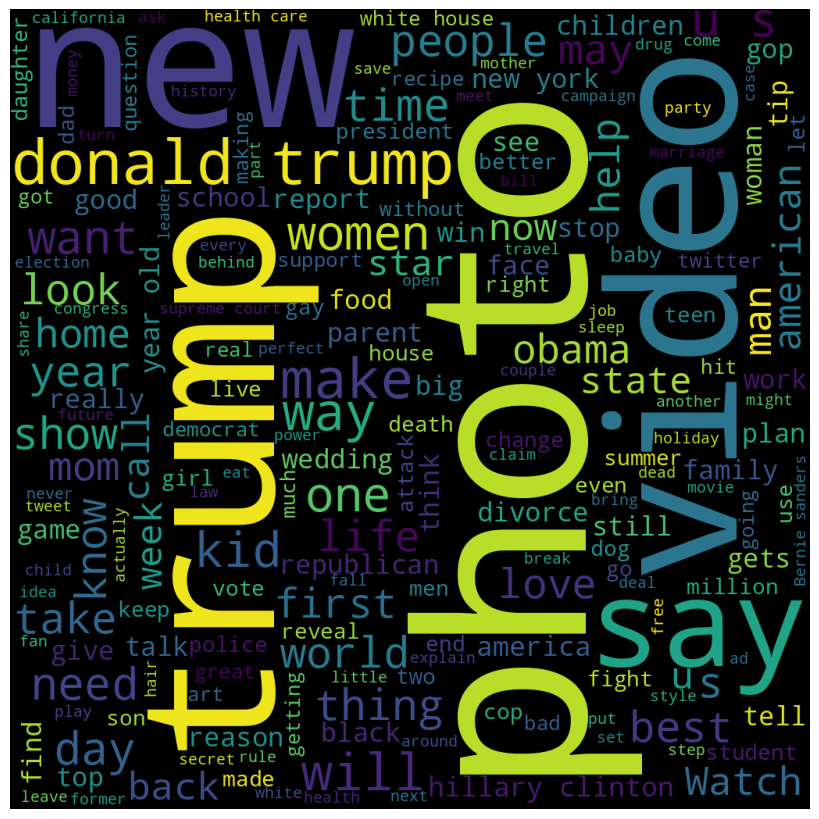

In [156]:
# Combine all non-humorous texts into a single string
all_nonhumorous_words = ' '.join(df_humor.loc[df_humor["humor"] == 0, "text"].tolist())

# Generate the WordCloud
wc = WordCloud(width=1024, height=1024, min_font_size=8, stopwords=STOPWORDS).generate(all_nonhumorous_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


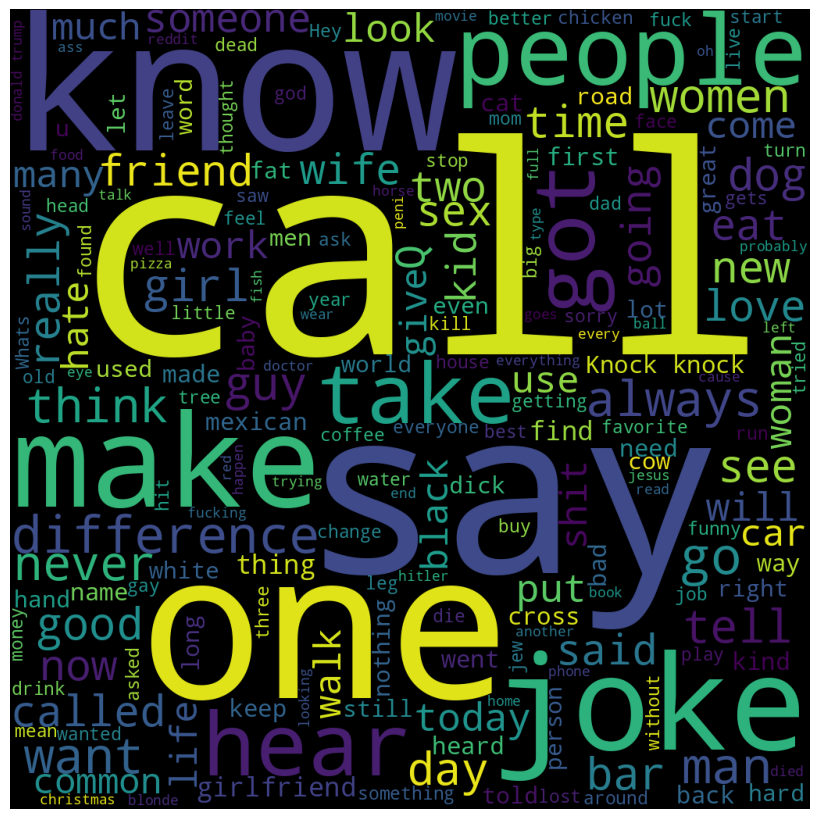

In [157]:
# Combine all humorous texts into a single string
all_humorous_words = ' '.join(list(df_humor[df_humor["humor"] == 1]["text"]))

# Generate the WordCloud
wc = WordCloud(width=1024, height=1024, min_font_size=8, stopwords=STOPWORDS).generate(all_humorous_words)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

Most of the text that includes a question mark '?' is labeled as True, which indicates the presence of humor.

<Axes: xlabel='Label', ylabel='Question_mark'>

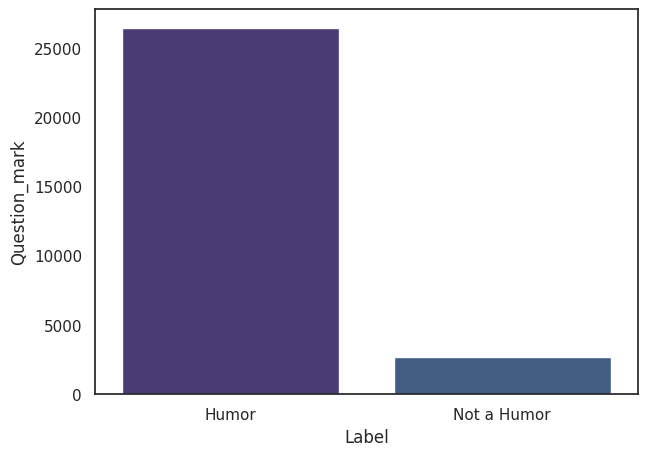

In [158]:
# Calculate how often "?" occurs in the data
humor_texts = df_humor[df_humor.humor == True]["text"]
no_humor_texts = df_humor[df_humor.humor == False]["text"]
qm_jokes = sum(["?" in text for text in humor_texts])
qm_no_jokes = sum(["?" in text for text in no_humor_texts])

# Create a dataframe to plot a bar chart
df_qm = pd.DataFrame({"Label":["Humor", "Not a Humor"], "Question_mark":[qm_jokes, qm_no_jokes]})

# Plot the bar chart
sns.set_palette("viridis")
sns.barplot(x="Label", y="Question_mark", data=df_qm)